In [1]:

%pprint

Pretty printing has been turned OFF


In [2]:

%run ../py/html_analysis.py
ha = HeaderAnalysis()
ea = ElementAnalysis()

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\CHILD_STR_CLF.pickle



----
# Download Job HTML

In [3]:

base_url = 'https://www.indeed.com'
site_url = base_url + '/jobs'
site_url = '?'.join([site_url, 'q=data+scientist'])
site_url = '&'.join([site_url, 'jt=fulltime'])
site_url = '&'.join([site_url, 'remotejob=032b3046-06a3-4876-8dfd-474eb5e7ed11'])
site_url = '&'.join([site_url, 'vjk=ca16b63c03e40c57'])
#site_url = '&'.join([site_url, 'pp=gQAPAAABdY7RMKwAAAABkQdgZAAkAQBEKPpaoZstIag3f-UtQXXG_HFSo1gfBp9OQ0B0TvZ4yMp4AAA'])
start_num = 0
assert s.pickle_exists('job_urls_list')
job_urls_list = s.load_object('job_urls_list')

space_regex = re.compile(r'[\s<>:"/\\\|\?\*_]+')
print_regex = re.compile(r'[\x9c-\x9d\uf0b7\u200b\ufb02]+')
s.encoding_type = ['latin1', 'iso8859-1', 'utf-8'][2]

In [8]:

from urllib.parse import urlparse, parse_qs
import requests
from IPython.display import clear_output

fccid_htmls_list = [fn.split('_')[-1] for fn in os.listdir(ha.SAVES_HTML_FOLDER)]
row_count = len(job_urls_list)
for i, job_url in enumerate(job_urls_list):
    qs = urlparse(job_url).query
    query_dict = parse_qs(qs)
    fccid_str = query_dict['fccid'][0]
    file_name = f'{fccid_str}.html'
    if file_name not in fccid_htmls_list:
        job_page = requests.get(url=job_url)
        job_soup = BeautifulSoup(job_page.content, 'lxml')
        if not len(job_soup.text):
            break
        title_str = job_soup.find_all(name='title')[0].text.strip()
        clear_output(wait=True)
        print(f'{title_str}')
        print(f'{i}/{row_count}: {job_url}')
        if 'CAPTCHA' in title_str:
            break
        file_name = space_regex.sub('_', title_str)
        file_name = f'{file_name}_{fccid_str}.html'
        file_path = os.path.join(ha.SAVES_HTML_FOLDER, file_name)
        body_soup = job_soup.find_all(name='body')[0]
        html_str = '<html><head><title>' + title_str + '</title></head><body>'
        with open(file_path, 'w', encoding='utf-8') as f:
            print(html_str, file=f)
            for div_tag in body_soup.find_all(name='div', class_='jobsearch-JobComponent-description'):
                for s in div_tag.select('template'):
                    s.extract()
                for s in div_tag.select('script'):
                    s.extract()
                div_str = div_tag.prettify(formatter='html')
                div_str = print_regex.sub('', div_str)
                print(div_str, file=f)
            print('</body></html>', file=f)
print('Complete.')

Sr Informatics Consultant Lead/Sr. Data Analyst - Hartford, CT - Indeed.com
587/3408: https://www.indeed.com/rc/clk?jk=7172785973cb1e4d&fccid=be3b11aa573faee7&vjs=3
Complete.


In [6]:

while start_num < 3000:
    page_url = '&'.join([site_url, f'start={start_num}'])
    start_num += 10
    site_page = requests.get(url=page_url)
    page_soup = BeautifulSoup(site_page.content, 'lxml')
    row_div_list = page_soup.find_all(name='div', class_=['row', 'result'])
    row_count = len(row_div_list)
    if row_count == 0:
        print('Nothing left')
        break
    for i, row_div in enumerate(row_div_list):
        link = row_div.find_all(name='a')[0]
        if 'title' in link.attrs:
            if 'href' in link.attrs:
                job_url = base_url + link['href']
                qs = urlparse(job_url).query
                query_dict = parse_qs(qs)
                if 'fccid' in query_dict:
                    job_urls_list.append(job_url)
                    s.store_objects(verbose=False, job_urls_list=job_urls_list)
                    clear_output(wait=True)
                    print(f'{page_url}')
                    print(f'{i}/{row_count}: {job_url}')

In [10]:

fccid_htmls_list = [fn.split('_')[-1] for fn in os.listdir(ha.SAVES_HTML_FOLDER)]
len(fccid_htmls_list)

454


----

In [21]:

def plot_child_str_predictions(file_name):
    HEADER_PATTERN_DICT = s.load_object('HEADER_PATTERN_DICT')
    child_strs_list = ha.get_child_strs_from_file(file_name)
    if file_name in HEADER_PATTERN_DICT:
        feature_dict_list = HEADER_PATTERN_DICT[file_name]
        feature_tuple_list = [(feature_dict['initial_tag'],
                               'H' if feature_dict['is_header'] else 'O') for feature_dict in feature_dict_list]
        prediction_dict_list = []
        for prediction_dict in ea.CRF.predict_marginals_single(ea.sent2features(feature_tuple_list)):
            prediction_dict = {'H': 1 - prediction_dict['O']}
            prediction_dict_list.append(prediction_dict)
    else:
        prediction_dict_list = []
        for child_str in child_strs_list:
            if(CLF_NAME == 'LdaModel'):
                H = ea.lda_predict_percent_is_header(child_str)
            else:
                H = ea.lr_predict_percent_is_header(child_str)
            prediction_dict = {'H': H}
            prediction_dict_list.append(prediction_dict)
    rows_list = []
    for child_str, marginals_dict in zip(child_strs_list, prediction_dict_list):
        row_dict = {'probability': marginals_dict['H']}
        if child_str in ha.NAVIGABLE_PARENT_IS_HEADER_DICT:
            row_dict['actual'] = ha.NAVIGABLE_PARENT_IS_HEADER_DICT[child_str] * 1.0
        else:
            row_dict['actual'] = np.nan
        rows_list.append(row_dict)
    df = pd.DataFrame(rows_list)
    coor = round(df.corr().loc['probability', 'actual'], 4)
    fig = plt.figure(figsize=(18, 2.5))
    ax = fig.add_subplot(1, 1, 1)
    title_text = fig.suptitle(t=f'Correlation to Actual: {coor}', y=1.55)
    AxesSubplot_obj = df.plot.line(ax=ax)
    ax.axis('off')
    for x, child_str in enumerate(child_strs_list):
        y = rows_list[x]['probability']
        if str(y) == 'nan':
            y = rows_list[x]['actual']
        if str(y) != 'nan':
            ax.annotate(f'{child_str[:20]}...', (x, y), ha='left', rotation=90)

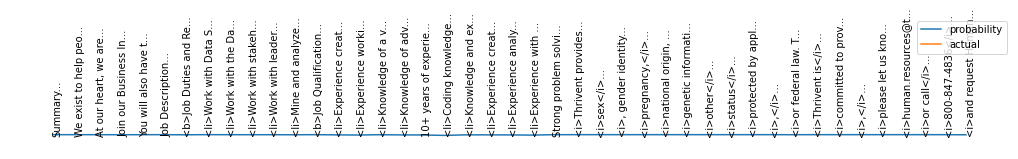

In [22]:

import random

files_list = os.listdir(ha.SAVES_HTML_FOLDER)
file_name = random.choice(files_list)
plot_child_str_predictions(file_name)

In [13]:

file_name, child_strs_list = random.choice(list(ea.CHILD_STRS_LIST_DICT.items()))
for child_str in child_strs_list:
    print()
    if(CLF_NAME == 'LdaModel'):
        X = ea.lda_predict_percent_is_header(child_str)
    else:
        X = ea.lr_predict_percent_is_header(child_str)
    display(HTML(ha.html2text(child_str, X)))


[0.91014981 0.08985019]



[0.91014981 0.08985019]



[0.91014981 0.08985019]



[0.91014981 0.08985019]



[0.91014981 0.08985019]



[0.91077712 0.08922288]



[0.91037849 0.08962151]



[0.9109828 0.0890172]



[0.91066947 0.08933053]



[0.91113048 0.08886952]



[0.91086734 0.08913266]



[0.91014981 0.08985019]



[0.91112015 0.08887985]



[0.91014981 0.08985019]



[0.91014981 0.08985019]



[0.91334724 0.08665276]



[0.91542216 0.08457784]



[0.91513343 0.08486657]



[0.9125277 0.0874723]



[0.91014981 0.08985019]



[0.91147438 0.08852562]



[0.91014981 0.08985019]



[0.91034914 0.08965086]



[0.91101732 0.08898268]



[0.9108566 0.0891434]



[0.91014981 0.08985019]



[0.91014981 0.08985019]



[0.937448 0.062552]



[0.91186019 0.08813981]



[0.915734 0.084266]



[0.91081199 0.08918801]



[0.91240252 0.08759748]



[0.91014981 0.08985019]



[0.91014981 0.08985019]



[0.91014981 0.08985019]


In [14]:

# The lower the IDF value of a word, the less unique it is to any particular HTML string
pd.DataFrame(ea.CS_TT.idf_, index=ea.CHILD_STR_CLF.get_feature_names(), columns=['idf_weights']).sort_values(by=['idf_weights'])

,idf_weights
and,1.842788
.,1.895326
</li,1.991051
<li,1.991051
to,2.081805
...,...
as a Military Friendly Employer,6.686975
as a Military Friendly,6.686975
as a Military,6.686975
as a result of,6.686975


In [19]:

import pandas as pd

# Re-transform the bag-of-words and tf-idf from the new manual scores
rows_list = [{'navigable_parent': navigable_parent, 'is_header': is_header} for navigable_parent, is_header in ha.NAVIGABLE_PARENT_IS_HEADER_DICT.items()]
child_str_df = pd.DataFrame(rows_list)

assert child_str_df.shape[0]
sents_list = child_str_df.navigable_parent.tolist()

In [16]:

# The more common the ngram is across documents, the lower its score (zero for ngrams missing in the chosen HTML string)
# The more unique an ngram is to our chosen HTML string, the higher its score
idx = sents_list.index([i for i in sents_list if '<h2 class' in i][0])
child_str = sents_list[idx]
print(child_str)
y_predict_proba = ea.lr_predict_percent_is_header(child_str)
print(y_predict_proba)
df = pd.DataFrame(ea.CS_TT.transform(ea.CHILD_STR_CLF.transform(sents_list))[idx].T.todense(),
                  index=ea.CHILD_STR_CLF.get_feature_names(), columns=['tfidf'])
mask_series = (df.tfidf > 0.0)
df[mask_series].sort_values('tfidf', ascending=False)

<h2 class="jobsearch-JobDescriptionSection-jobDescriptionTitle icl-u-xs-my--md" id="jobDescriptionTitle">Full Job Description</h2>
[[0.91014981 0.08985019]]


,tfidf
jobDescriptionTitle,0.028774
</h2,0.014387
jobsearch,0.014387
md id,0.014387
md,0.014387
...,...
xs my md id jobDescriptionTitle,0.014387
class,0.013515
Description,0.013515
Full,0.012023


In [126]:

sample_list = []
sample_list = random.sample([(w, i) for w, i in ea.CS_CV_VOCAB.items() if '<' in w], 20)
sorted([(w, round(ea.CS_TT.idf_[i], 2)) for w, i in sample_list], key=lambda x: x[1], reverse=False)

[('. </div', 4.78), ('<b Careers with Optum .', 5.7), ('beginning employment . </i', 5.7), ('based on your experience </p', 5.7), ('<i We are committed to', 5.7), ('<li Retirement plan', 5.7), ('<b A candidate must', 5.7), ('Flexible schedule </li', 5.7), ('Takes to Succeed : </b', 5.7), ('non technical audiences alike </li', 5.7), ('<li Doctorate Required', 5.7), ('<p Work Location : </p', 5.7), ('audiences alike </li', 5.7), ('<p Benefits :', 5.7), ('<h2', 5.7), ('401 k </li', 5.7), ('inclusion </p', 5.7), ('the role for you </p', 5.7), ('Virtual meetings </li', 5.7), ('<i Were proud to be', 5.7)]

In [168]:

[fn for fn in dir(ea.CS_CV) if not fn.startswith('_')]

['analyzer', 'binary', 'build_analyzer', 'build_preprocessor', 'build_tokenizer', 'decode', 'decode_error', 'dtype', 'encoding', 'fit', 'fit_transform', 'fixed_vocabulary_', 'get_feature_names', 'get_params', 'get_stop_words', 'input', 'inverse_transform', 'lowercase', 'max_df', 'max_features', 'min_df', 'ngram_range', 'preprocessor', 'set_params', 'stop_words', 'stop_words_', 'strip_accents', 'token_pattern', 'tokenizer', 'transform', 'vocabulary', 'vocabulary_']

In [87]:

random.sample([w for w in ea.CS_CV.get_feature_names()], 20)

['capability for', 'Come In', 'You', 'example', 'Experience', '80', 'language', 'learning to', 'and the', 'safe and', 'graduate', 'Schedule :', 'Yelp', 'Bachelor s', 'experience </li', 'Supplemental Pay', 'automate', 'work', 'persistence', 'full time']


----

In [533]:

import sys

command_str = f'{sys.executable} -m pip install --upgrade html2text'
print(command_str)
!{command_str}

C:\Users\dev\Anaconda3\envs\jh\python.exe -m pip install --upgrade html2text

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.



  Using cached html2text-2020.1.16-py3-none-any.whl (32 kB)
